In [1]:
from matplotlib import pyplot as plt
import os
import pandas as pd
import numpy as np
import math
import tensorflow as tf
import cv2
from clearn.utils.data_loader import TrainValDataIterator
from sklearn.metrics import accuracy_score
from clearn.utils.utils import read_label, get_label_reconstructed
from clearn.config import ExperimentConfig, get_base_path
from clearn.utils.annotation_utils import read_label, get_label_reconstructed, compute_accuracy,get_combined_and_corrected_annotations
from clearn.utils.annotation_utils import get_images, plot_reconstructed_image, get_annotations, plot_reconstructed_image_with_label
from matplotlib.ticker import MultipleLocator
from clearn.utils.utils import save_image


%matplotlib inline

/home/sunilv/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/sunilv/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/sunilv/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/sunilv/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: 

In [2]:
pd.set_option('display.max_rows',100)

In [3]:
N_3 = 32
N_2 = 128
N_1 = 64
Z_DIM = 10
run_id = 1

ROOT_PATH = "/home/sunilv/concept_learning_data/"

In [4]:
MODEL_NAME ="VAE"

annotator = "SUNIL"
#NUMBER_OF_ROWS = 16
#NUM_DIGITS_PER_ROW = 4
ANNOTATED_CSV = "annotation.csv"
eval_interval = 300

num_label_files = 2
num_rows_per_image = 16
num_digits_per_row = 4
assembled_annotation_folder = "assembled_annotation/"

In [5]:
accuracy_dict =dict()
max_epoch = 5
z_dim = 10
run_ids = [1]
exp_config_unsupervised = ExperimentConfig(ROOT_PATH, 4, Z_DIM, [N_1, N_2, N_3], None, name="unsupervised")
exp_config_supervised = ExperimentConfig(ROOT_PATH,
                                         4,
                                         Z_DIM,
                                         [N_1, N_2, N_3],
                                         ExperimentConfig.NUM_CLUSTERS_CONFIG_TWO_TIMES_ELBOW,
                                         name="supervised"
                                        )
configs = {}
configs[exp_config_unsupervised.name] = exp_config_unsupervised
configs[exp_config_supervised.name] = exp_config_supervised

for run_id in run_ids:
    for key, config in configs.items():
        if not config.check_and_create_directories(run_id, create=False):
            raise Exception("Directories does not exist")
        
        BASE_PATH = get_base_path(ROOT_PATH, z_dim ,N_3, N_2, config.num_cluster_config, run_id=run_id)
        PREDICTION_RESULTS_PATH = os.path.join(BASE_PATH, "prediction_results/")

    
        ANNOTATED_PATH = BASE_PATH + assembled_annotation_folder
        label_file = PREDICTION_RESULTS_PATH + "/label_test_{:02d}.csv"
        labels = read_label(label_file, num_label_files)

        accuracy_df = compute_accuracy(labels,
                                       ANNOTATED_PATH,
                                       max_epoch,
                                       num_label_files,
                                       num_rows_per_image,
                                       num_digits_per_row,
                                       eval_interval)
        
        accuracy_dict[config.name + "_"+str(run_id)] = [max(accuracy_df["Accuracy"].values), accuracy_df]
    

Reading annotation from  /home/sunilv/concept_learning_data/Exp_10_032_128_1/assembled_annotation/
Reading annotation from  /home/sunilv/concept_learning_data/Exp_10_032_128_TWO_TIMES_ELBOW_1/assembled_annotation/


In [6]:
keys = [k for k in accuracy_dict.keys()]
num_evaluations = accuracy_dict[keys[0]][1].shape[0]

unsupervised_1
supervised_1


/home/sunilv/.local/lib/python3.6/site-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


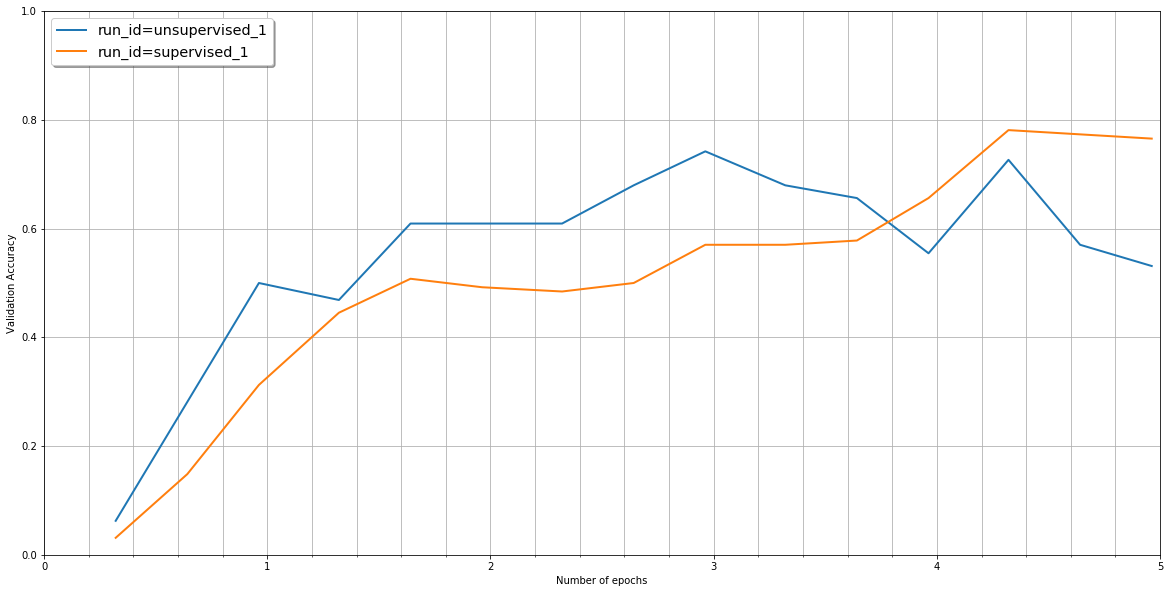

In [7]:
plt.figure(figsize=(20,10))
plot_filename = "reconstruction_accuracy_different_runs.jpg"
total = np.zeros(num_evaluations)
for run_id, result in accuracy_dict.items():
    max_accuracy = result[0]
    accuracy_df = result[1]
    x = accuracy_df["Epochs"].values
    x = x.reshape(x.shape[0])
    y = accuracy_df["Accuracy"].values
    y = y.reshape(y.shape[0])

    plt.plot(x,y,label="run_id={}".format(run_id),lw=2)
    plt.xlabel("Number of epochs")
    plt.ylabel("Validation Accuracy")
    print(run_id)
    #total = total + y
#average = total / len(run_ids)
#plt.plot(x, average,label = "Average")

plt.legend(loc='upper left', shadow=True, fontsize='x-large')
plt.xticks([i for i in range(10)])
plt.xlim(0,max_epoch)
plt.ylim(0,1)
plt.grid(which="both")
plt.axes().xaxis.set_minor_locator(MultipleLocator(0.2))
plt.savefig(os.path.join(ROOT_PATH,"combined_analysis",plot_filename),bbox="tight") 
#plt.savefig(os.path.join(DOC_PATH,plot_filename), bbox="tight")

In [8]:
for run_id, result in accuracy_dict.items():
    accuracy = result[1]["Accuracy"].values
    max_index = np.argmax(accuracy)
    print(run_id, result[1]["Total_Batches_Finished"].values[max_index], 
          result[1]["Epochs"].values[max_index],
          max(accuracy), max_index)

unsupervised_1 2770 2.962566844919786 0.7421875 8
supervised_1 4040 4.320855614973262 0.78125 12


# Compare  result after same number of training batch with different run

In [9]:
keys =[key for  key in configs]
config = configs[keys[0]]

In [10]:
data_iterator = TrainValDataIterator.from_existing_split(config.split_name,
                                                         config.DATASET_PATH,
                                                         config.BATCH_SIZE,
                                                         manual_labels_config=config.manual_labels_config,
                                                         manual_annotation_file=None)
#batch_eval_images, batch_eval_labels, manual_labels = data_iterator.get_next_batch("val")

Warning None path does not exist. Creating random prior with uniform distribution


In [11]:
label_images = []
start_eval_batch = 0
num_eval_batches = data_iterator.get_num_samples("val") // config.BATCH_SIZE
label_dir = config.DATASET_PATH
for _idx in range(start_eval_batch, num_eval_batches):
    batch_eval_images, batch_eval_labels, manual_labels = data_iterator.get_next_batch("val")
    print(_idx,batch_eval_images.shape)
    manifold_w = 4
    tot_num_samples = config.BATCH_SIZE
    manifold_h = tot_num_samples // manifold_w
    label_images.append(batch_eval_images[:manifold_h * manifold_w, :, :, :])

for _idx in range(start_eval_batch, num_eval_batches):
    file = "im_" + str(_idx) + ".png"
    save_image(label_images[_idx], [manifold_h, manifold_w], label_dir + file)
    
    

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


0 (64, 28, 28, 1)
1 (64, 28, 28, 1)
(64, 28, 28, 1)
(64, 28, 28, 1)


In [12]:
label_images = {}
for _idx in range(start_eval_batch, num_eval_batches):
    file = "im_" + str(_idx) + ".png"
    im = cv2.imread(label_dir + file)
    key = file.rsplit(".", 1)[0]
    label_images[key] = im

In [14]:
epoch = 0
step = 1
batch = epoch * 935 + step * eval_interval

In [18]:
def get_correct(column_name, row):
    num_correct = 0
    for i,j in zip(row[column_name], row["labels"]):
        if i == j:
            num_correct += 1
    return num_correct

Reading annotation from  /home/sunilv/concept_learning_data/Exp_10_032_128_1/assembled_annotation/
Reading annotation from  /home/sunilv/concept_learning_data/Exp_10_032_128_TWO_TIMES_ELBOW_1/assembled_annotation/


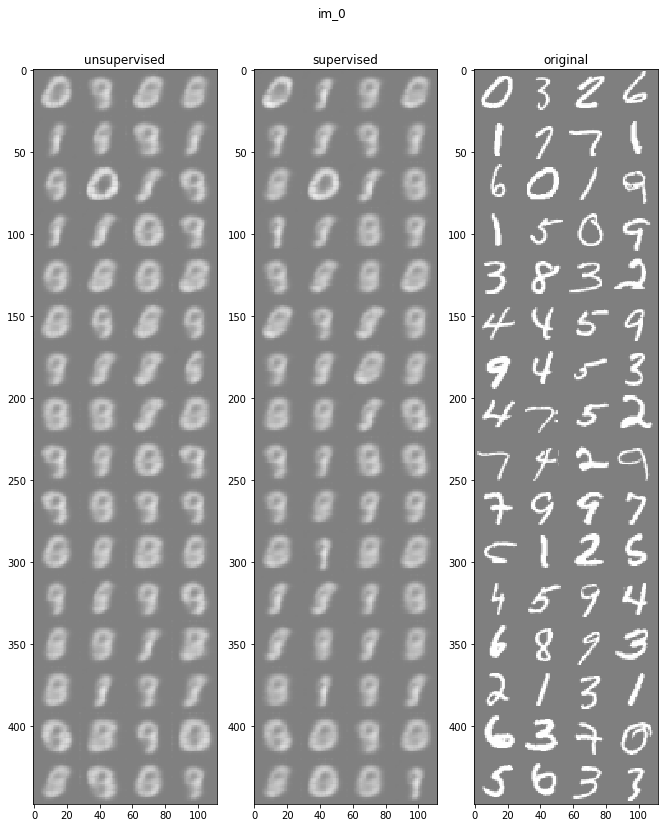

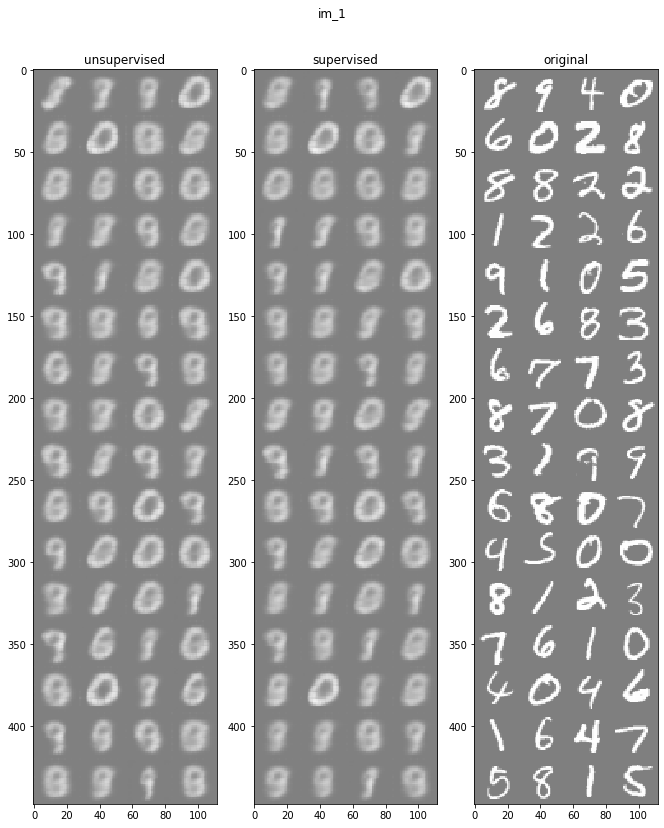

In [21]:
data_dict = dict()
image_dict =dict()
run_id = 1

for key, exp_config in configs.items():
    BASE_PATH = get_base_path(ROOT_PATH, z_dim ,N_3, N_2, exp_config.num_cluster_config, run_id=run_id)
    PREDICTION_RESULTS_PATH = os.path.join(BASE_PATH, "prediction_results/")
    ANNOTATED_PATH = BASE_PATH + assembled_annotation_folder

    images = get_images(PREDICTION_RESULTS_PATH, batches=batch)
    image_dict[key] = images
    df, _ = get_combined_and_corrected_annotations(ANNOTATED_PATH, batches=batch)
    df = df.rename(columns={"text":f"text_{exp_config.name}"})
    data_dict[key] = df
# merge all data frames   
df_combined =None
for key in keys:
    if df_combined is None:
        df_combined = data_dict[key]
    else:
        df_combined = df_combined.merge(data_dict[key], on=["epoch","step","_idx","num_rows_annotated","batch"])
#Add labels column
label_file = PREDICTION_RESULTS_PATH + "/label_test_{:02d}.csv"
labels = read_label(label_file, num_label_files)
labels_list =[]
for k in labels.keys():
    for i in range(int(labels[k].shape[0] / num_digits_per_row)):
        text = ""
        for j in range(num_digits_per_row):
            l = str(int(labels[k][ i* num_digits_per_row + j]))
            text = text + l
        labels_list.append(text)
df_combined["labels"] = labels_list
columns = ['epoch', 'step', '_idx', 'num_rows_annotated','batch','text_unsupervised','text_supervised', 'labels']
df_combined = df_combined[columns]

#df_combined["unsupervised_correct"] = df_combined["text_unsupervised"] == df_combined["labels"]
df_combined["unsupervised_correct"] = df_combined.apply(lambda x:get_correct("text_unsupervised", x),axis=1)

df_combined["supervised_correct"] = df_combined.apply(lambda x:get_correct("text_supervised", x),axis=1)
plot_reconstructed_image({keys[0]:image_dict[keys[0]], keys[1]:image_dict[keys[1]], "original":label_images}, "im_0")
plot_reconstructed_image({keys[0]:image_dict[keys[0]], keys[1]:image_dict[keys[1]], "original":label_images}, "im_1")

In [23]:
df_combined.head(130)

,epoch,step,_idx,num_rows_annotated,batch,text_unsupervised,text_supervised,labels,unsupervised_correct,supervised_correct
0,0,1,0,1,300,xxxx,xxxx,0326,0,0
1,0,1,0,2,300,xxxx,xxxx,1771,0,0
2,0,1,0,3,300,x0xx,x0xx,6019,1,1
3,0,1,0,4,300,xxxx,xxxx,1509,0,0
4,0,1,0,5,300,xxxx,xxxx,3832,0,0
5,0,1,0,6,300,xxxx,xxxx,4459,0,0
6,0,1,0,7,300,xxxx,xxxx,9453,0,0
7,0,1,0,8,300,xxxx,xxxx,4752,0,0
8,0,1,0,9,300,xxxx,xxxx,7429,0,0
9,0,1,0,10,300,xxxx,xxxx,7997,0,0


In [25]:
def compare_columns(row):
    if row["num_correct_run_id_2"] < row["num_correct_run_id_1"]:
        return True
    else:
        return False

In [26]:
df_combined["count_run_id_2_less_than_1"] = df_combined.apply(lambda x: compare_columns(x),
                                                     axis = 1)
                                                            

In [27]:
def mark_rows(im, rows_to_mark):
    left, top = (0, 0)
    right, bottom = (222, 28)
    height = bottom - top
    im_with_mark = im.copy()
    for row in rows_to_mark:
        top = (row - 1) * height 
        bottom = top + height
        cv2.rectangle(im_with_mark, (left, top), (right, bottom), (0, 0, 255), 2)
    return im_with_mark

In [28]:
def get_marked_image(images_run_id):
    rows_to_mark_dict = dict()
    for image_no in [0,1]:
        key = f"im_{image_no}"
        _df = df_combined[ (df_combined["count_run_id_2_less_than_1"]) & (df_combined["_idx"] == image_no)]
        rows_to_mark = _df["num_rows_annotated"].values
        im = images_run_id[key]
        marked_im = mark_rows(im, rows_to_mark)
        rows_to_mark_dict[key] = {"rows_to_mark":rows_to_mark,
                                  "dataframe":_df,
                                  "marked_image": marked_im
                                 }
    return rows_to_mark_dict
    

In [29]:
rows_to_mark_dict_1 = get_marked_image(images_run_id_1)
images_run_id_1_m = dict()
for key, im in images_run_id_1.items():
    images_run_id_1_m[key] = rows_to_mark_dict_1[key]["marked_image"]


images_run_id_2_m = dict()
rows_to_mark_dict_2 = get_marked_image(images_run_id_2)
for key, im in images_run_id_2.items():
    images_run_id_2_m[key] = rows_to_mark_dict_2[key]["marked_image"]


In [30]:
import matplotlib
def plot_reconstructed_image_with_label(images_dict, im_name, labels_list):
    offset = -0.11
    num_rows_per_image = 16
    vertical_step = ((1 - 2 * abs(offset)) /num_rows_per_image ) - 0.00875
    dpi = matplotlib.rcParams['figure.dpi']
    num_cols = 3
    keys = [k for k in images_dict.keys()]
    im_1 = images_dict[keys[0]][im_name]
    im_2 = images_dict[keys[1]][im_name]
    im_3 = images_dict[keys[2]]
    print(im_1.shape)

    height, width = im_1.shape[0], im_1.shape[1]
    figsize = num_cols * 2 * width / float(dpi), 2 * height / float(dpi)
    fig = plt.figure(figsize=figsize)
    fig.suptitle(im_name)
    ax = fig.add_subplot(1, num_cols, 1)
    ax.imshow(im_1, cmap="Greys")
    plt.title(keys[0])

    ax = fig.add_subplot(1, num_cols, 2)
    ax.imshow(im_2, cmap="Greys")
    plt.title(keys[1])
    
    ax = fig.add_subplot(1, num_cols, 3)
    ax.imshow(im_3, cmap="Greys")
    plt.title(keys[2])
    
    
    fig.tight_layout()


W0713 16:49:31.809082 140735495193472 image.py:664] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(448, 112, 3)


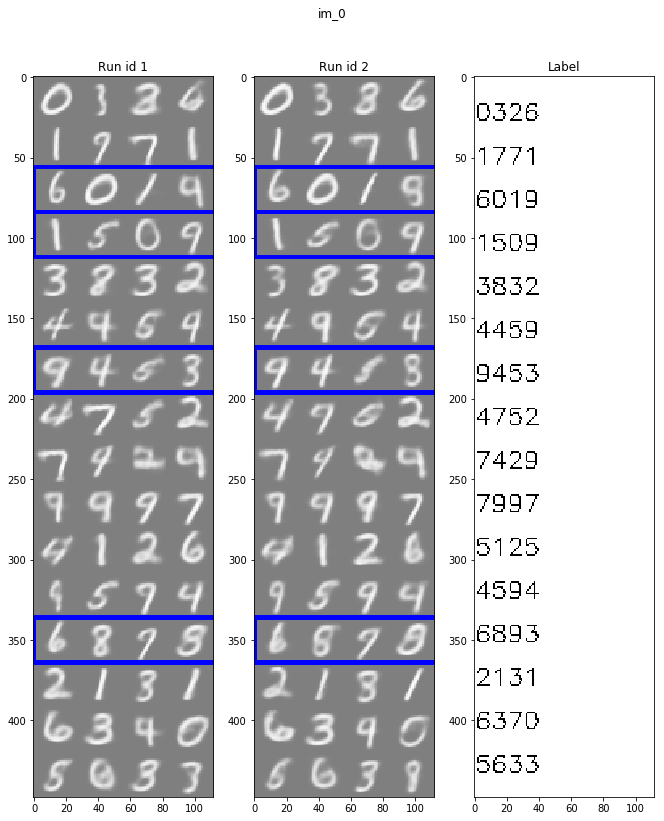

In [31]:
label_image = 256 * np.ones_like(im)

font = cv2.FONT_HERSHEY_SIMPLEX 
# fontScale 
fontScale = 0.5
   
# Blue color in BGR 
color = (0,0,0)
  
# Line thickness of 2 px 
thickness = 1

for i in range(16):
    cv2.putText(label_image, labels_list[i], (0, (i+1) * 27),font,  
                   fontScale, color, thickness, cv2.LINE_AA)

plot_reconstructed_image_with_label({"Run id 1":images_run_id_1_m,
                                     "Run id 2":images_run_id_2_m,
                                     "Label":label_image,
                                    },
                                    "im_0",
                                    labels_list
                                   )


In [32]:
corrected_annotation_0 = [["6019","601x"], ["1509","1x09"], ["94x3","94xx"], ["68xx","xxxx"]]


W0713 16:49:33.518342 140735495193472 image.py:664] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(448, 112, 3)


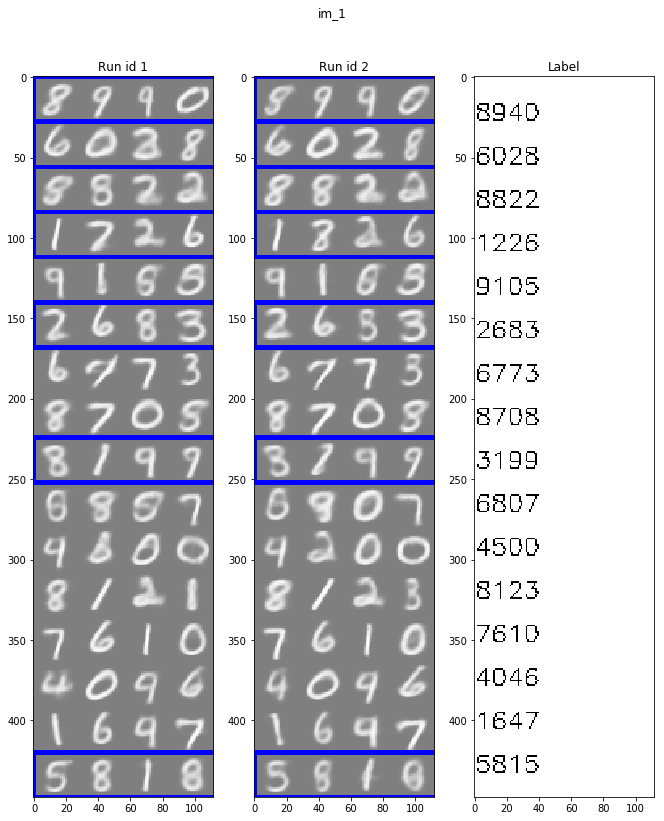

In [33]:
label_image = 256 * np.ones_like(im)
images_run_id_2_m["Label"] = 256 * np.ones_like(im)
for i in range(16,32):
    cv2.putText(label_image, labels_list[i], (0, (i-16+1) * 27),font,  
                   fontScale, color, thickness, cv2.LINE_AA)

plot_reconstructed_image_with_label({"Run id 1":images_run_id_1_m,
                                     "Run id 2":images_run_id_2_m,
                                    "Label":label_image,
                                    },
                                    "im_1",
                                    labels_list
                                   )

In [34]:
corrected_annotation_1 = [["8990","x990"], ["60x8","6028"], ["1x26","1xx6"], ["91xx","91xx"],
                         ["2683", "26x3"],["819x","xx9x"],["5818","581x"]]


In [35]:
corrected_annotation_run_id_0_im_0 = [l[0] for l in corrected_annotation_0]
corrected_annotation_run_id_1_im_0 = [l[1] for l in corrected_annotation_0]

In [36]:
corrected_annotation_run_id_0_im_1 = [l[0] for l in corrected_annotation_1]
corrected_annotation_run_id_1_im_1 = [l[1] for l in corrected_annotation_1]

In [37]:
from copy import deepcopy
df_corrected = deepcopy(df)
df_corrected_2 = deepcopy(df_2)

In [38]:
image_no = 0
df_corrected.loc[df_corrected["num_rows_annotated"].isin(rows_to_mark_dict_1["im_0"]["rows_to_mark"]) & (df_corrected["_idx"] == image_no),
       "text_run_id_1"] = corrected_annotation_run_id_0_im_0
image_no = 1
df_corrected.loc[df_corrected["num_rows_annotated"].isin(rows_to_mark_dict_1["im_1"]["rows_to_mark"]) & (df_corrected["_idx"] == image_no),
       "text_run_id_1"] = corrected_annotation_run_id_0_im_1 

In [39]:
image_no = 1
df_corrected_2.loc[df_corrected_2["num_rows_annotated"].isin(rows_to_mark_dict_2["im_0"]["rows_to_mark"]) & (df_corrected_2["_idx"] == image_no),
       "text_run_id_2"] = corrected_annotation_run_id_1_im_0
image_no = 1
df_corrected_2.loc[df_corrected_2["num_rows_annotated"].isin(rows_to_mark_dict_2["im_1"]["rows_to_mark"]) & (df_corrected_2["_idx"] == image_no),
       "text_run_id_2"] = corrected_annotation_run_id_1_im_1 

In [40]:
run_id = 1
BASE_PATH = get_base_path(ROOT_PATH, z_dim ,N_3, N_2, exp_config.num_cluster_config, run_id=run_id)
PREDICTION_RESULTS_PATH = os.path.join(BASE_PATH, "prediction_results/")
ANNOTATED_PATH = BASE_PATH + "manual_annotation_corrected"

In [41]:
df_corrected.to_csv(os.path.join(ANNOTATED_PATH, f"annotation_corrected_batch_{batch}.csv"))

In [42]:
run_id = 2
BASE_PATH = get_base_path(ROOT_PATH, z_dim ,N_3, N_2, exp_config.num_cluster_config, run_id=run_id)
PREDICTION_RESULTS_PATH = os.path.join(BASE_PATH, "prediction_results/")
ANNOTATED_PATH = BASE_PATH + "manual_annotation_corrected"

In [43]:
df_corrected_2.to_csv(os.path.join(ANNOTATED_PATH, f"annotation_corrected_batch_{batch}.csv"))

In [44]:
df_combined_corrected = df_corrected.merge(df_corrected_2, on=["epoch","step","_idx","num_rows_annotated","batch"])
df_combined_corrected["labels"] = labels_list

In [45]:
df_combined_corrected["num_correct_run_id_1"] = df_combined_corrected.apply(lambda x:get_correct("text_run_id_1", x) ,axis = 1)
df_combined_corrected["num_correct_run_id_2"] = df_combined_corrected.apply(lambda x:get_correct("text_run_id_2", x) ,axis = 1)

In [46]:
df_combined_corrected.sum()

epoch                                                                 128
step                                                                   96
_idx                                                                   16
num_rows_annotated                                                    272
text_run_id_1           0xxx1907601915093832xxxx94x3x7x27xx99997x126x5...
batch                                                              148480
text_run_id_2           0x861771601x1xx93832x9x4x4xx49x27xx9x997x12695...
labels                  0326177160191509383244599453475274297997512545...
num_correct_run_id_1                                                   78
num_correct_run_id_2                                                   67
dtype: object

In [47]:
df_combined.sum()

epoch                                                                       128
step                                                                         96
_idx                                                                         16
num_rows_annotated                                                          272
text_run_id_1                 0xxx1907601915093832xxxx94x3x7x27xx99997x126x5...
batch                                                                    148480
text_run_id_2                 0x861771601x1xx93832x9x4x4xx49x27xx9x997x12695...
labels                        0326177160191509383244599453475274297997512545...
num_correct_run_id_1                                                         87
num_correct_run_id_2                                                         76
count_run_id_2_less_than_1                                                   11
dtype: object